# Model creation - random forest

In [1]:
# imports
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
# read processed csv file
train = pd.read_csv("train_p.csv")
print(train.head())

train_ind = train.copy()
train_ind.drop(labels=["outcome", "id", "season", "home_team_goal", "away_team_goal", "date", "Unnamed: 0", "home_team_api_id", "away_team_api_id"], axis=1,inplace=True)
print(train_ind.head())

print(len(train_ind.columns))

   Unnamed: 0    id     season  stage                 date  home_team_api_id  \
0           0  1729  2008/2009      1  2008-08-17 00:00:00                 1   
1           1  1730  2008/2009      1  2008-08-16 00:00:00                 2   
2           2  1731  2008/2009      1  2008-08-16 00:00:00                 3   
3           3  1732  2008/2009      1  2008-08-16 00:00:00                 4   
4           4  1733  2008/2009      1  2008-08-17 00:00:00                 5   

   away_team_api_id  home_team_goal  away_team_goal  B365H  ...  PSH   PSD  \
0                13               1               1   1.29  ...  2.2  3.67   
1                16               1               0   1.20  ...  2.2  3.67   
2                12               0               1   5.50  ...  2.2  3.67   
3                20               2               1   1.91  ...  2.2  3.67   
4                18               4               2   1.91  ...  2.2  3.67   

    PSA   WHH  WHD    WHA   VCH  VCD    VCA  outco

In [3]:
def normalize(df):
    dfMod = df.copy()
    for column in dfMod.columns:
        dfMod[column] =(dfMod[column]-dfMod[column].min())/(dfMod[column].max()-dfMod[column].min())
        #dfMod = dfMod.rename(columns = {column:f"{column}Normalized"})
    return dfMod

dfMod = normalize(train_ind)


In [4]:
# check correlation

cor_df = pd.DataFrame(dfMod.iloc[:,2:19].corr())

#cor_df.to_csv("correlation_matrix.csv")


In [7]:
from sklearn.model_selection import train_test_split


X = dfMod[["IWH","LBH", "PSH", "PSD","PSA","WHH","VCH", "VCD", "IWD"]] #used reduced dataset of the variables that are highly correlated with less than 4 other variables(else remove the columns to keep)
y = train["outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [10]:
# random forest model

# fit final model
forest_model = RandomForestClassifier(max_features = "log2", n_estimators=1000)

print(train_ind.head())
print(train_ind.columns)
forest_model.fit(X_train,y_train)


   stage  B365H  B365D  B365A  IWH  IWD    IWA   LBH  LBD    LBA  PSH   PSD  \
0      1   1.29    5.5  11.00  1.3  4.4   8.50  1.25  4.5  10.00  2.2  3.67   
1      1   1.20    6.5  15.00  1.2  5.2  11.00  1.20  5.0  11.00  2.2  3.67   
2      1   5.50    3.6   1.67  4.5  3.5   1.65  4.50  3.3   1.67  2.2  3.67   
3      1   1.91    3.4   4.20  1.8  3.3   3.80  1.80  3.2   4.00  2.2  3.67   
4      1   1.91    3.4   4.33  2.0  3.2   3.30  1.83  3.2   3.75  2.2  3.67   

    PSA   WHH  WHD    WHA   VCH  VCD    VCA  
0  3.64  1.25  4.5  10.00  1.28  5.5  12.00  
1  3.64  1.17  5.5  12.00  1.25  6.0  13.00  
2  3.64  5.50  3.3   1.57  5.50  3.8   1.65  
3  3.64  1.83  3.2   3.75  1.90  3.5   4.35  
4  3.64  1.91  3.2   3.50  1.90  3.5   4.35  
Index(['stage', 'B365H', 'B365D', 'B365A', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD',
       'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA'],
      dtype='object')


RandomForestClassifier(max_features='log2', n_estimators=1000)

In [9]:
#defining parameters
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=forest_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.482381 using {'max_features': 'log2', 'n_estimators': 1000}
0.454048 (0.028582) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.478452 (0.027595) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.481429 (0.028353) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.458214 (0.025003) with: {'max_features': 'log2', 'n_estimators': 10}
0.476905 (0.028582) with: {'max_features': 'log2', 'n_estimators': 100}
0.482381 (0.029507) with: {'max_features': 'log2', 'n_estimators': 1000}


In [11]:
y_pred = forest_model.predict(X_test)
print('Accuracy - classifier on test set: {:.4f}'.format(forest_model.score(X_test, y_test)))

Accuracy - classifier on test set: 0.5161


In [12]:
# model evaluation - cross validation

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(forest_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


TypeError: 'numpy.float64' object is not callable

In [107]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 83  21  62]
 [ 45  30  74]
 [ 34  45 166]]


# TEST DATASET


In [13]:
test_set = pd.read_csv("test_p.csv")
test_set.columns

Index(['Unnamed: 0', 'id', 'season', 'stage', 'date', 'home_team_api_id',
       'away_team_api_id', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA',
       'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH',
       'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD',
       'GBA', 'BSH', 'BSD', 'BSA', 'outcome'],
      dtype='object')

In [14]:
test_ind =test_set.copy()
test_ind.drop(labels=["id", "Unnamed: 0","outcome", "season", "date", "home_team_api_id", "away_team_api_id", "GBH", "GBD", "GBA", "BSH", "BSD", "BSD", "BSA", "SJA", "SJD", "SJH"], axis=1,inplace=True)
print(test_ind.head())

   stage  B365H  B365D  B365A   BWH   BWD    BWA   IWH  IWD   IWA  ...    LBA  \
0     15   1.29   6.00  13.00  1.26  6.25  10.50  1.22  5.5  12.0  ...  12.00   
1     15   1.36   5.25   9.50  1.38  5.00   8.00  1.35  4.8   7.6  ...   9.00   
2     15   2.10   3.60   3.75  2.10  3.30   3.40  2.00  3.3   3.6  ...   3.60   
3     15   1.44   4.50   9.00  1.44  4.33   8.00  1.40  4.4   7.3  ...   8.50   
4     15   5.75   4.33   1.62  5.50  4.00   1.62  5.40  3.7   1.6  ...   1.57   

    PSH   PSD    PSA   WHH   WHD    WHA   VCH   VCD    VCA  
0  1.28  6.14  13.53  1.29  5.00  12.00  1.29  5.75  13.00  
1  1.38  5.23   9.75  1.36  4.50   9.00  1.36  5.25  10.00  
2  2.06  3.63   3.88  2.00  3.30   3.75  2.05  3.60   3.80  
3  1.43  4.70   9.06  1.44  3.80   9.00  1.44  4.50   9.00  
4  5.75  4.35   1.62  5.50  3.75   1.62  6.00  4.20   1.62  

[5 rows x 22 columns]


In [15]:
print("Columns in test dataset including null values:")
list_names_test = []
for i in test_ind.columns:
    if test_ind[i].isnull().values.any() == True:
        print(i)
        list_names_test.append(i)
    else:
        continue

Columns in test dataset including null values:
BWH
BWD
BWA


22


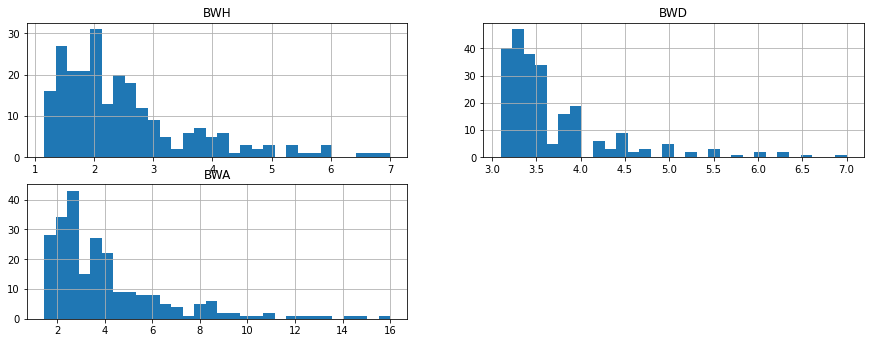

In [16]:

print(len(test_ind.columns))

for i, column in enumerate(test_ind[list_names_test].columns):
    ax = plt.subplot(17, 2, i + 1)
    test_ind[column].hist(bins = 30, ax = ax, figsize = (15, 50))
    ax.set_title(column) 
plt.show()



In [17]:

test_ind= test_ind.fillna(test_ind.median())
test_ind.head()

test_ind.drop(labels=['BWH', 'BWD', 'BWA'], axis=1, inplace=True)

test_ind.columns

Index(['stage', 'B365H', 'B365D', 'B365A', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD',
       'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA'],
      dtype='object')

In [18]:
model_test2 = forest_model.predict(test_ind[["IWH","LBH", "PSH", "PSD","PSA","WHH","VCH", "VCD", "IWD"]])
model_test2

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

# Submission file

In [19]:
upload_df = pd.DataFrame(test_set["id"])

upload_df["outcome"] = model_test2

upload_df = upload_df.set_index("id")

upload_df

,outcome
id,
4449,-1
4450,-1
4451,-1
4452,-1
4453,-1
...,...
4704,-1
4705,-1
4706,-1


In [20]:
upload_df.to_csv("random_forest_outcome_6_param_short_log_2.csv")